In [ ]:
import pandas as pd

Here the sensor are considered to be powered by the system

In [ ]:
# Define the power usage for each device in each state

#in mW
power_usage = {
    "Device 1": {"off": 0, "idle": 2, "active": 50},
    "Device 2": {"off": 0, "idle": 1, "active": 100},
    "Device 3": {"off": 0, "idle": 0.001, "active": 2}
}

transition_times = {
"Device 1": {"off_to_idle": 2, "off_to_active": 2.01, "idle_to_active": 0.01, "active_to_idle": 0.01, "idle_to_off": 2, "active_to_off": 2.01},
"Device 2": {"off_to_idle": 0, "off_to_active": 0, "idle_to_active": 0, "active_to_idle": 0, "idle_to_off": 0, "active_to_off": 0},
"Device 3": {"off_to_idle": 0, "off_to_active": 0, "idle_to_active": 0, "active_to_idle": 0, "idle_to_off": 0, "active_to_off": 0}
}

transition_powers = {
"Device 1": {"off_to_idle": 2, "off_to_active": 2, "idle_to_active": 3, "active_to_idle": 4, "idle_to_off": 5, "active_to_off": 6},
"Device 2": {"off_to_idle": 3, "off_to_active": 2, "idle_to_active": 4, "active_to_idle": 5, "idle_to_off": 6, "active_to_off": 7},
"Device 3": {"off_to_idle": 4, "off_to_active": 2, "idle_to_active": 5, "active_to_idle": 6, "idle_to_off": 7, "active_to_off": 8}
}

# Define the current state for each device
current_state = {"Device 1": "off", "Device 2": "off", "Device 3": "off"}

# Define the tasks as a DataFrame
df_tasks = pd.DataFrame(data={
    "name": ["Task 1", "Task 2", "Task 3", "Task 4"],
    "Device 1": ["active", "idle", "off", "active"],
    "Device 2": ["active", "active", "idle", "active"],
    "Device 3": ["active", "idle", "idle", "off"],
    "deadline": [100, 50, 110, 70],
    "WCET": [40, 45, 30, 20],
    "Priority": [1, 2, 3, 4]
})

df_tasks['AET'] = .75*df_tasks['WCET']

current_time = 0
start_time = []
end_time = []

###with transition times

In [ ]:


# Continuously monitor the power usage of each device
while True:
    df_tasks["Slack Time"] = df_tasks["deadline"] - (current_time + df_tasks["WCET"])
    df_tasks = df_tasks.sort_values(by=['Slack Time', 'Priority'], ascending=[True, False])
    df_sch_tasks = df_tasks
    for _, task in df_tasks.iterrows():
        can_execute = True
        for device in ["Device 1", "Device 2", "Device 3"]:
            if task[f"{device}"] not in power_usage[device]:
                can_execute = False
                break
        if can_execute:
            device_active_energy = 0
            
            # Execute the task
            print(f"Executing {task['name']}...")
            transition = f"{current_state[device]}to{task[f'{device}']}"
            for device in ["Device 1", "Device 2", "Device 3"]:
                device_active_energy += power_usage[device][task[f"{device}"]]*task.AET
                
                #transition
                device_transition_energy = 0
                current_state_name = current_state[device]
                next_state_name = task[f"{device}"]
                if current_state_name != next_state_name:
                    transition_key = f"{current_state_name}_to_{next_state_name}"
                    transition_time = transition_times[device][transition_key]
                    transition_power = transition_powers[device][transition_key]
                    device_transition_energy = transition_time * transition_power
                    device_active_energy += device_transition_energy


                current_state[device] = task[f"{device}"]
                
            df_sch_tasks.loc[task.name,"device_active_energy"] = device_active_energy
            df_sch_tasks.loc[task.name,"device_transition_energy"] = device_transition_energy
            df_sch_tasks.loc[task.name,"total_energy"] = device_active_energy + device_transition_energy


            start_time.append(current_time)
            current_time += task['AET']
            end_time.append(current_time)

            df_tasks = df_tasks.drop(index=task.name)
            if df_tasks.empty:
                print("All Tasks Done!")
                break
        else:
            # Invalid state, do not execute task
            print(f"Skipping {task['name']}, invalid state.")

    if df_tasks.empty:
        break

df_sch_tasks['start_time'] = start_time
df_sch_tasks['end_time'] = end_time

Executing Task 2...
Executing Task 4...
Executing Task 1...
Executing Task 3...
All Tasks Done!


### ignoring transion times

In [ ]:
# schedule df_tasks
schedule = []
while not df_tasks.empty:
    # update slack time for all df_tasks
    df_tasks['Slack Time'] = df_tasks['deadline'] - (current_time + df_tasks['WCET'])
    # sort df_tasks based on LST and priority
    df_tasks = df_tasks.sort_values(by=['Slack Time', 'Priority'], ascending=[True, False])
    # select next task
    next_task = df_tasks.iloc[0]
    schedule.append(next_task)
    start_time.append(current_time)
    # update current time
    current_time += next_task['AET']
    # remove task from list of df_tasks
    df_tasks = df_tasks.drop(next_task.name)
    end_time.append(current_time)

df_sch_tasks = pd.DataFrame(schedule, columns = ['name','deadline','WCET','Priority','AET','Slack Time','Device 1','Device 2','Device 3'])
df_sch_tasks['start_time'] = start_time
df_sch_tasks['end_time'] = end_time

In [ ]:
# Continuously monitor the power usage of each device
df_tasks = df_sch_tasks
while True:
    for _, task in df_tasks.iterrows():
        can_execute = True
        for device in ["Device 1", "Device 2", "Device 3"]:
            if task[f"{device}"] not in power_usage[device]:
                can_execute = False
                break
        if can_execute:
            device_active_power = 0
            device_active_energy = 0
            
            # Execute the task
            print(f"Executing {task['name']}...")
            for device in ["Device 1", "Device 2", "Device 3"]:
                device_active_power += power_usage[device][task[f"{device}"]]
                device_active_energy += power_usage[device][task[f"{device}"]]*task.AET

                current_state[device] = task[f"{device}"]
            
            df_sch_tasks.loc[task.name,"device_active_power"] = device_active_power   
            df_sch_tasks.loc[task.name,"device_active_energy"] = device_active_energy
            df_sch_tasks.loc[task.name,"device_total_energy"] = device_active_energy

            df_tasks = df_tasks.drop(index=task.name)
            if df_tasks.empty:
                print("All Tasks Done!")
                break
        else:
            # Invalid state, do not execute task
            print(f"Skipping {task['name']}, invalid state.")

    if df_tasks.empty:
        break

df_sch_tasks = df_sch_tasks.reset_index()

Executing Task 2...
Executing Task 4...
Executing Task 1...
Executing Task 3...
All Tasks Done!


In [ ]:
display(df_sch_tasks)

,index,name,deadline,WCET,Priority,AET,Slack Time,Device 1,Device 2,Device 3,start_time,end_time,device_active_power,device_active_energy,device_total_energy
0,1,Task 2,50,45,2,33.75,5.00,idle,active,idle,0.00,33.75,102.001,3442.53375,3442.53375
1,3,Task 4,70,20,4,15.00,16.25,active,active,off,33.75,48.75,150.000,2250.00000,2250.00000
2,0,Task 1,100,40,1,30.00,11.25,active,active,active,48.75,78.75,152.000,4560.00000,4560.00000
3,2,Task 3,110,30,3,22.50,1.25,off,idle,idle,78.75,101.25,1.001,22.52250,22.52250


In [ ]:
max_device_power = 0
for device in ["Device 1", "Device 2", "Device 3"]:
    max_device_power += power_usage[device]['active']

In [ ]:
df_sch_tasks['max_device_power'] = max_device_power
df_sch_tasks['max_device_energy'] = df_sch_tasks['max_device_power']*df_sch_tasks['AET']

##plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30, 12.5)
plt.rcParams['font.size'] = 18

In [ ]:
df_plot = df_sch_tasks
df_plot['freq'] = 1
df_plot['start_time'] = df_plot['AET'].cumsum()-df_plot['AET']

In [ ]:
titles = df_sch_tasks['name']
xmax = df_plot['AET'].sum()+10

ax1x = df_plot['start_time'].tolist()
ax1y = df_plot['freq'].tolist()
ax1w = df_plot['AET'].tolist()
ax1title = 'Task profile of non-DPM schedule (E=100%)'
ax1_color = [(r,r,r) for r in np.linspace(0, 1, len(ax1w))]

ax2x = df_plot['start_time'].tolist()
ax2y = df_plot['freq'].tolist()
ax2w = df_plot['AET'].tolist()
ax2title = 'Task profile of DPM schedule (E='+ str(round((df_plot['device_total_energy'].sum()/df_plot['max_device_energy'].sum()*100),2)) +'%)'
ax2_color = [(r,r,r) for r in np.linspace(0, 1, len(ax2w))]

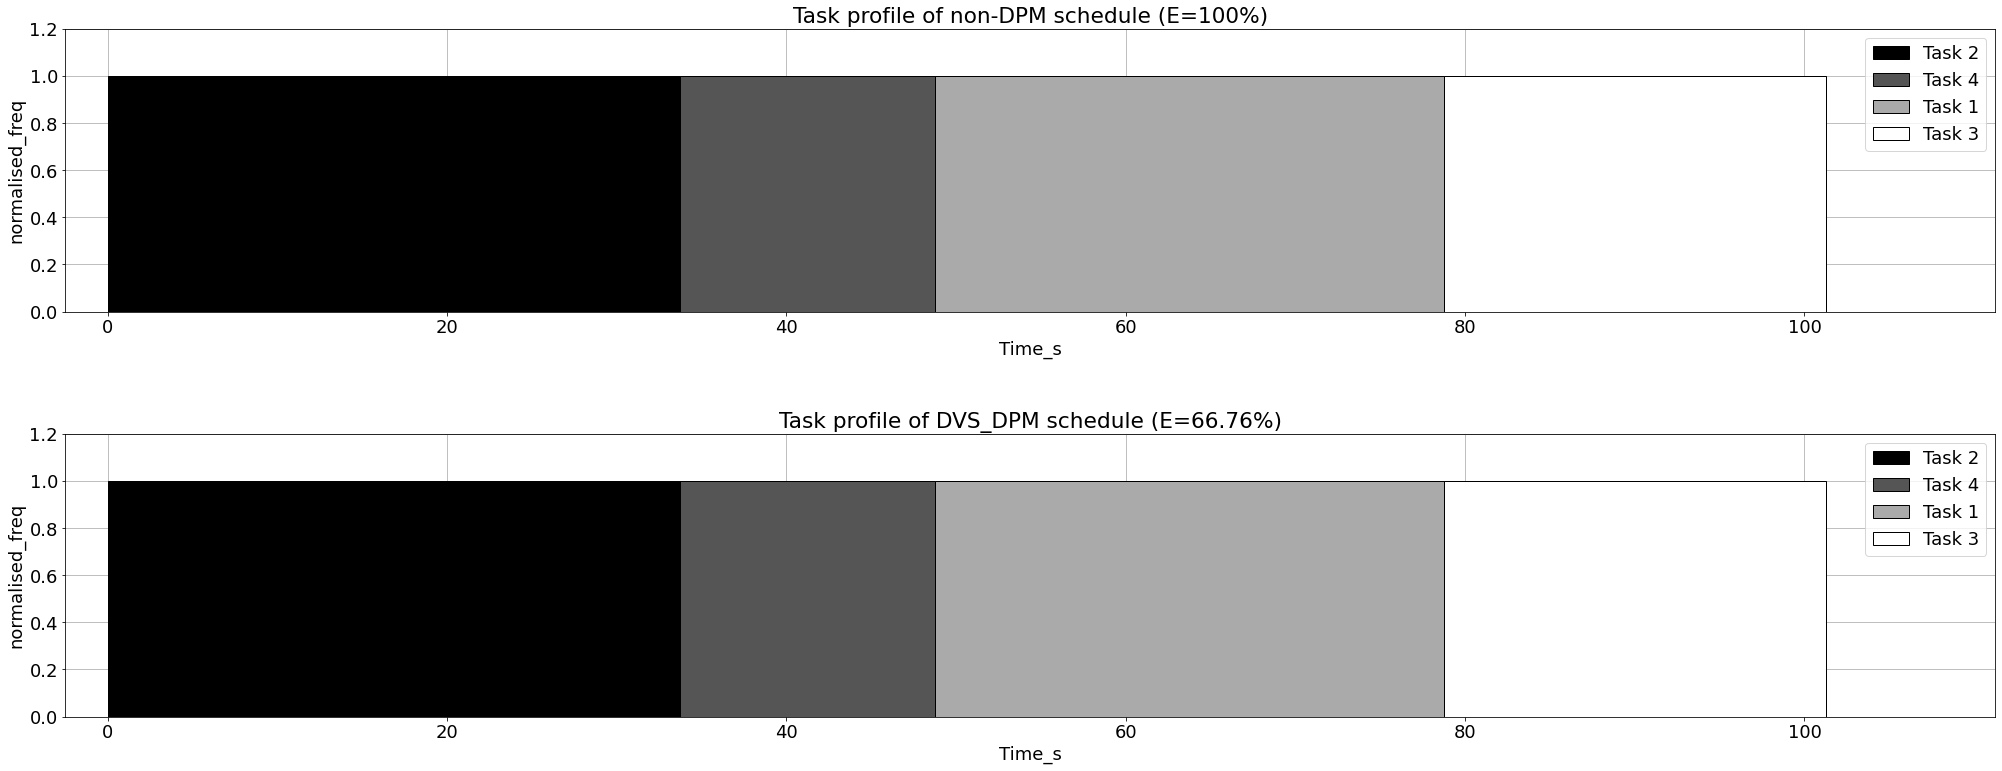

In [ ]:
fig, [ax1,ax2] = plt.subplots(2, 1)
fig.tight_layout(pad=5)
for i in range(len(ax1x)):
    ax1.bar(ax1x[i], ax1y[i], label=titles[i], align = 'edge', width = ax1w[i], color = ax1_color[i],edgecolor='k',zorder=3)
ax1.set(xlabel = 'Time_s', ylabel = 'normalised_freq',xlim = (-2.5,xmax), ylim = (0,1.2), title = ax1title)
for i in range(len(ax1x)):
    ax2.bar(ax2x[i], ax2y[i], label=titles[i], align = 'edge', width = ax2w[i], color = ax2_color[i],edgecolor='k',zorder=3)
ax2.set(xlabel = 'Time_s', ylabel = 'normalised_freq',xlim = (-2.5,xmax), ylim = (0,1.2), title = ax2title)
ax1.legend()
ax2.legend()
ax1.grid(zorder=0)
ax2.grid(zorder=0)

In [ ]:
df_plot_dev = df_sch_tasks[['Device 1','Device 2','Device 3']]
df_plot_dev = df_plot_dev.set_index(df_sch_tasks['name'])

In [ ]:
df_plot_dev1 = df_plot_dev.replace(['active','idle','off'],3)
df_plot_dev2 = df_plot_dev.replace(['active','idle','off'],[3,2,1])


In [ ]:
display(df_plot_dev2)

,Device 1,Device 2,Device 3
name,,,
Task 2,2,3,2
Task 4,3,3,1
Task 1,3,3,3
Task 3,1,2,2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30, 17.5)
plt.rcParams['font.size'] = 20

In [ ]:
ax1title = 'Task profile of non-DPM schedule (E=100%)'
ax2title = 'Task profile of DPM schedule (E='+ str(round((df_plot['device_total_energy'].sum()/df_plot['max_device_energy'].sum()*100),2)) +'%)'
color = ['black', 'grey', 'white']

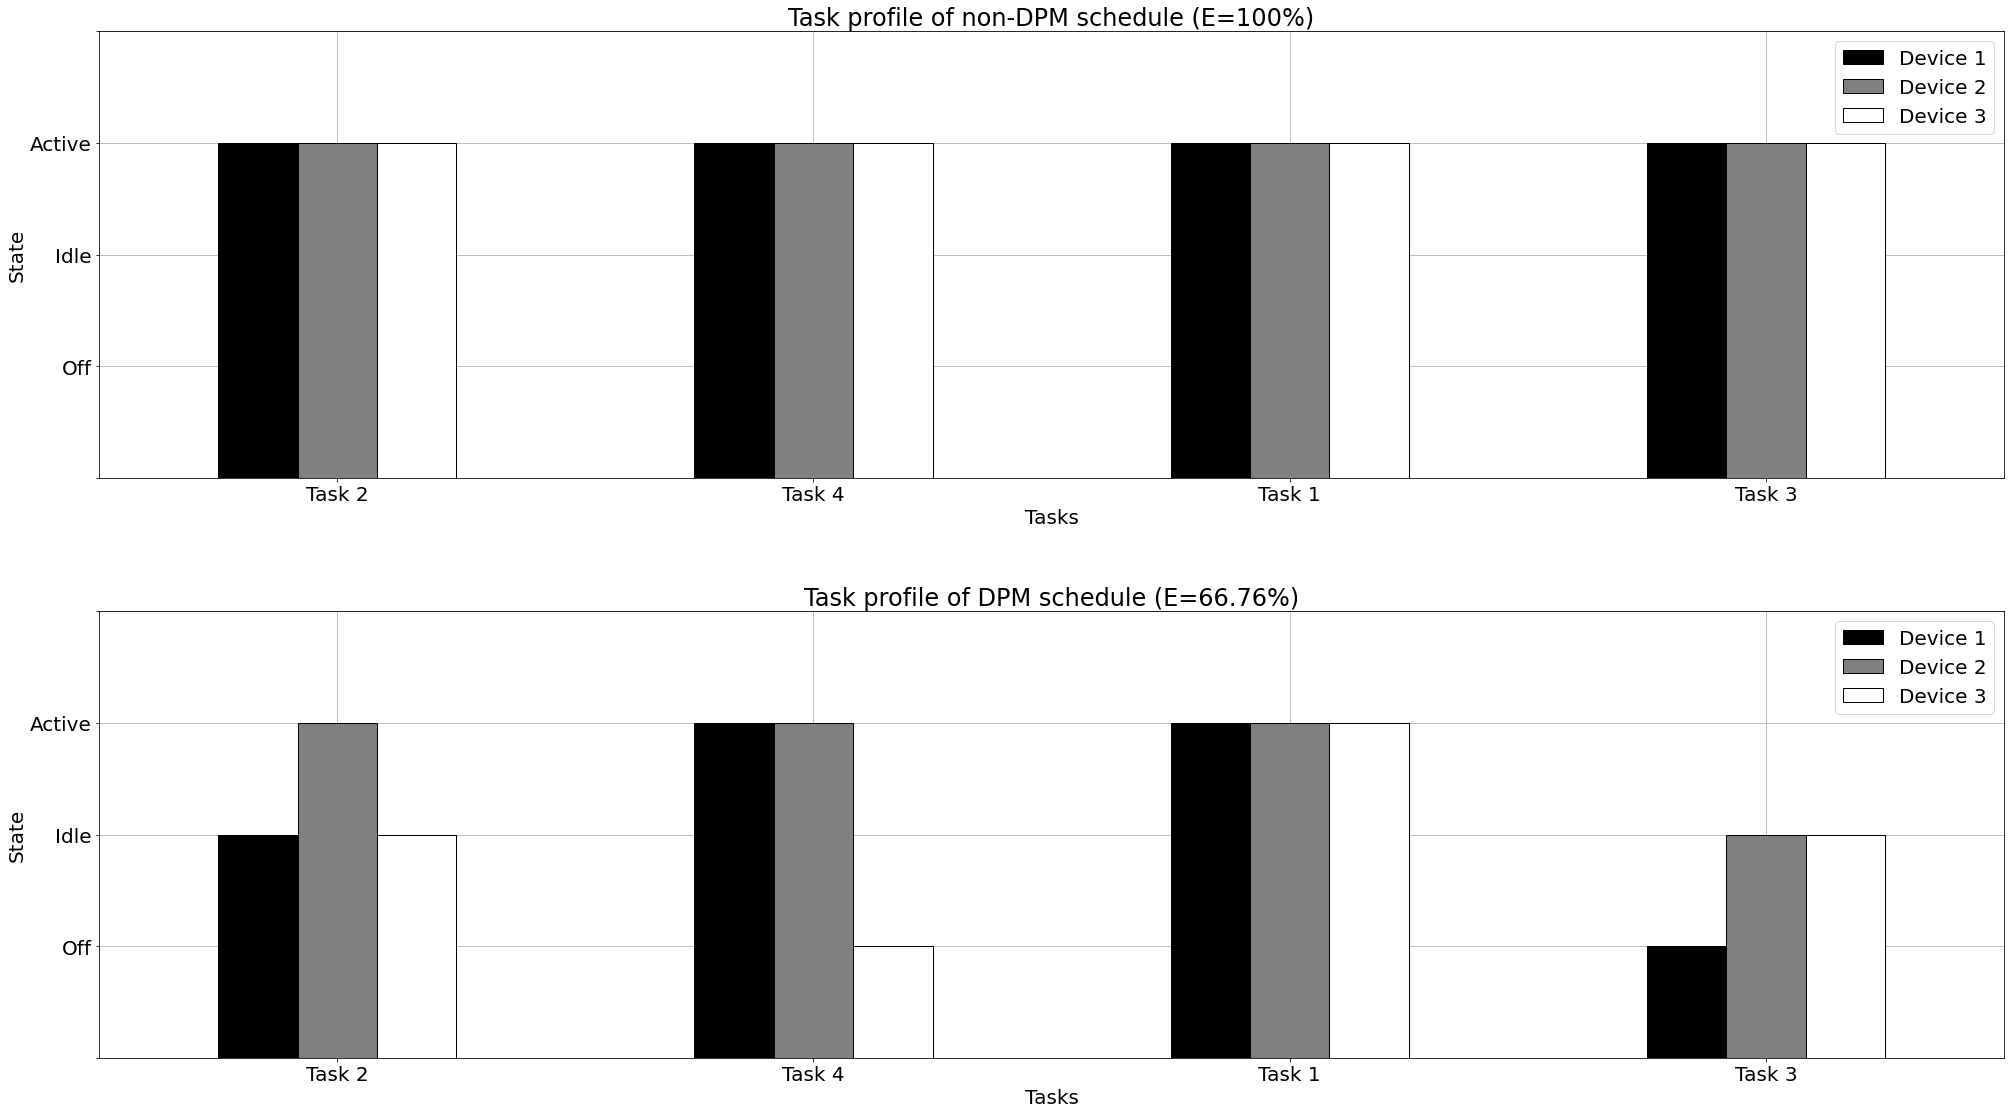

In [ ]:
fig, [ax1,ax2] = plt.subplots(2, 1)
fig.tight_layout(pad=5)

plot1 = df_plot_dev1.plot.bar(yticks=([0,1,2,3,4]),rot = 0,zorder=3, color = color,edgecolor='k',title = ax1title, ax = ax1)
plot1.set_xlabel('Tasks')
plot1.set_ylabel('State')
plot1.set_yticklabels(['','Off','Idle','Active',''])
plot1.legend(loc = 1)
plot1.grid(zorder=0)

plot2 = df_plot_dev2.plot.bar(yticks=([0,1,2,3,4]),rot = 0,zorder=3, color = color,edgecolor='k',title = ax2title, ax = ax2)
plot2.set_xlabel('Tasks')
plot2.set_ylabel('State')
plot2.set_yticklabels(['','Off','Idle','Active',''])
plot2.grid(zorder=0)